In [ ]:
using Plots
using JSON
using DataFrames

default(framestyle=:box)

In [ ]:
function load_step_metrics(name)
    data = JSON.parsefile("../logs/$name.json")
    DataFrame(data["step_metrics"])
end

function compare_time_calc_state(scenario; model="", backends=["nogrid", "cpu", "gpu"], steps=[])
    items = ["$(scenario)_$(model != "" ? "$model_" : "")$(backend)" for backend in backends]
    dfs = []

    plot(xlabel="Pedestrian count", ylabel="Process time per step / s")
    for (i, item) in enumerate(items)
        df = load_step_metrics(item)
        plot!(df.active_ped_count, df.time_calc_state, label=backends[i])
        push!(dfs, df)
    end

    for (j, step) in enumerate(steps)
        base_time = 0.0

        for (i, item) in enumerate(items)
            time = dfs[i].time_calc_state[step]
            if i == 1
                ped_count = dfs[i].active_ped_count[step]
                base_time = time
                println("step: $step, pedestrian_count: $ped_count")
            end
            println("$item: $(time*1000.0) ms (x $(base_time / time))")
        end
        println("---")
    end

    plot!()
end

## Compare calculation time between backends

In [ ]:
compare_time_calc_state("bn2", backends=["cpu14", "gpu14"], steps=[5000])
# plot!(ylim = [0.0, 0.05])

In [ ]:
savefig("output/bn2.svg");

In [ ]:
compare_time_calc_state("bn2", backends=["nogrid14", "cpu14"], steps=[])
plot!(ylim=[0.0, 0.5])
savefig("output/bn2_cpu.svg");

In [ ]:
compare_time_calc_state("sparse", backends=["nogrid", "cpu", "gpu"], steps=[1000, 3000])

In [ ]:
savefig("output/sparse.svg");

## Profile GPU kernel

In [ ]:
df = load_step_metrics("bn2_gpu")

plot(xlabel="Pedestrian count", ylabel="Process time per step / s")
plot!(df.active_ped_count, [df.time_spawn, df.time_calc_state, df.time_calc_state_kernel], labels=["spawn" "calc_state" "calc_state_kernel"])

## Profile spawn implementations

In [ ]:
items = ["bn2_gpu", "bn2_pariter"]

plot(xlabel="Pedestrian count", ylabel="Process time per step / s")

for item in items
    df = load_step_metrics(item)
    plot!(df.active_ped_count, df.time_spawn, label=item)
end

plot!()

## Optimize work size

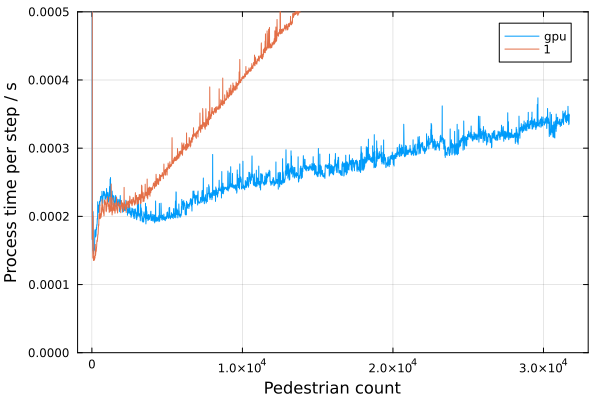

In [ ]:
compare_time_calc_state("sparse", backends=["gpu", "1"])
plot!(ylim=[0.0, 0.0005])